# 5TERA_chi2.ipynb
### Marcus Viscardi,    May 04, 2022

Moving things over from 5TERA_analyses to limit overlapping code

In [203]:
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', None)

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

from nanoporePipelineCommon import *

print("imports done")

imports done


In [3]:
reads_df_genes_raw, compressed_df_genes_raw = load_and_merge_lib_parquets(["xrn-1-5tera", "xrn-1-5tera-smg-6"], drop_sub_n=1, add_tail_groupings=False, drop_failed_polya=False, group_by_t5=True)
print("done.")

Loading readAssignments file from: /data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.allChrs.parquet... Done.
Looking for files for libraries: ['xrn-1-5tera', 'xrn-1-5tera-smg-6']
Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Loading parquet for xrn-1-5tera lib... Done.
'original_chr_pos' column already found in dataframe, skipping adjustment for 5'ends!
Loading parquet for xrn-1-5tera-smg-6 lib... Done.
'original_chr_pos' column already found in dataframe, skipping adjustment for 5'ends!
Finished assignment merge!. . .
Read counts post gene assignment:  937835
Read counts post unassigned drop:  636409
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_i

Counting reads per gene: 100%|██████████| 31278/31278 [00:00<00:00, 51790.24it/s]


Gene counts pre sub-1 gene_hits drop:  31278
Gene counts post sub-1 gene_hits drop:  31278
done.


In [86]:
compressed_df_genes_short = compressed_df_genes_raw.copy()[["lib", "chr_id", "gene_id", "gene_name", "t5", "gene_hits", "gene_rpm"]]
compressed_df_genes_short.query("gene_name == 'rpl-12'")

,lib,chr_id,gene_id,gene_name,t5,gene_hits,gene_rpm
10219,xrn-1-5tera,IV,WBGene00004424,rpl-12,-,1759,3710.195550
10220,xrn-1-5tera,IV,WBGene00004424,rpl-12,+,49,103.353941
25572,xrn-1-5tera-smg-6,IV,WBGene00004424,rpl-12,-,513,3160.618569
25573,xrn-1-5tera-smg-6,IV,WBGene00004424,rpl-12,+,6,36.966299


In [197]:
conversion_dict = {"xrn-1-5tera": "n2",
                   "xrn-1-5tera-smg-6": "s6"}
ans = [y for x, y in compressed_df_genes_short.groupby(['lib', 't5'], as_index=False)]
df_dict = {}
for i, df in enumerate(ans):
    lib = df.lib.unique()[0]
    t5 = df.t5.unique()[0]
    df = df[["chr_id", "gene_id", "gene_name", "gene_hits", "gene_rpm"]]
    df = df.rename(columns={col: f'{col}_{conversion_dict[lib]}_t5{t5}' for col in df.columns if col not in ["chr_id", "gene_id", "gene_name"]})
    df_dict[(conversion_dict[lib], t5)] = df.set_index(["chr_id", "gene_id", "gene_name"])
    print((conversion_dict[lib], t5))
    print(df_dict[(conversion_dict[lib], t5)].query("gene_name == 'rpl-12'"))

super_df = pd.concat(df_dict.values(), axis=1, join='outer').fillna(0)
super_df

('n2', '+')
                                 gene_hits_n2_t5+  gene_rpm_n2_t5+
chr_id gene_id        gene_name                                   
IV     WBGene00004424 rpl-12                   49          103.354
('n2', '-')
                                 gene_hits_n2_t5-  gene_rpm_n2_t5-
chr_id gene_id        gene_name                                   
IV     WBGene00004424 rpl-12                 1759        3,710.196
('s6', '+')
                                 gene_hits_s6_t5+  gene_rpm_s6_t5+
chr_id gene_id        gene_name                                   
IV     WBGene00004424 rpl-12                    6           36.966
('s6', '-')
                                 gene_hits_s6_t5-  gene_rpm_s6_t5-
chr_id gene_id        gene_name                                   
IV     WBGene00004424 rpl-12                  513        3,160.619


gene_hits_n2_t5+  gene_rpm_n2_t5+  \
chr_id gene_id        gene_name                                      
I      WBGene00000001 aap-1                 2.000            4.219   
       WBGene00000006 aat-5                 1.000            2.109   
       WBGene00000010 aat-9                 0.000            0.000   
       WBGene00000020 abt-2                 0.000            0.000   
       WBGene00000023 abt-5                 1.000            2.109   
...                                           ...              ...   
X      WBGene00271701 F10D7.10              1.000            2.109   
       WBGene00284849 C03A3.9               0.000            0.000   
       WBGene00284855 C04C11.25             0.000            0.000   
       WBGene00303024 H40L08.7              8.000           16.874   
       WBGene00303081 T23F2.13              0.000            0.000   

                                 gene_hits_n2_t5-  gene_rpm_n2_t5-  \
chr_id gene_id        gene_name                                      
I      WBGene00000001 aap-1                18.000           37.967   
       WBGene00000006 aat-5                 2.000            4.219   
       WBGene00000010 aat-9                 7.000           14.765   
       WBGene00000020 abt-2                 4.000            8.437   
       WBGene00000023 abt-5                 3.000            6.328   
...                                           ...              ...   
X      WBGene00271701 F10D7.10              0.000            0.000   
       WBGene00284849 C03A3.9               2.000            4.219   
       WBGene00284855 C04C11.25             1.000            2.109   
       WBGene00303024 H40L08.7              7.000           14.765   
       WBGene00303081 T23F2.13              1.000            2.109   

                                 gene_hits_s6_t5+  gene_rpm_s6_t5+  \
chr_id gene_id        gene_name                                      
I      WBGene00000001 aap-1                 1.000            6.161   
       WBGene00000006 aat-5                 0.000            0.000   
       WBGene00000010 aat-9                 0.000            0.000   
       WBGene00000020 abt-2                 0.000            0.000   
       WBGene00000023 abt-5                 0.000            0.000   
...                                           ...              ...   
X      WBGene00271701 F10D7.10              0.000            0.000   
       WBGene00284849 C03A3.9               0.000            0.000   
       WBGene00284855 C04C11.25             0.000            0.000   
       WBGene00303024 H40L08.7              0.000            0.000   
       WBGene00303081 T23F2.13              0.000            0.000   

                                 gene_hits_s6_t5-  gene_rpm_s6_t5-  
chr_id gene_id        gene_name                                     
I      WBGene00000001 aap-1                 1.000            6.161  
       WBGene00000006 aat-5                 1.000            6.161  
       WBGene00000010 aat-9                 1.000            6.161  
       WBGene00000020 abt-2                 5.000           30.805  
       WBGene00000023 abt-5                 0.000            0.000  
...                                           ...              ...  
X      WBGene00271701 F10D7.10              1.000            6.161  
       WBGene00284849 C03A3.9               3.000           18.483  
       WBGene00284855 C04C11.25             0.000            0.000  
       WBGene00303024 H40L08.7              1.000            6.161  
       WBGene00303081 T23F2.13              0.000            0.000  

[13508 rows x 8 columns]

In [43]:
# Below was all test code

# def make_contingency_table(row, as_df=True):
#     array = np.array([[row["gene_hits_n2_t5-"][0], row["gene_hits_s6_t5-"][0]],
#                       [row["gene_hits_n2_t5+"][0], row["gene_hits_s6_t5+"][0]]])
#     if as_df:
#         little_df = pd.DataFrame(array, columns=['n2', 'smg-6'], index=['t5 -', 't5 +'])
#         return little_df
#     else:
#         return array
# 
# make_contingency_table(super_df.query("gene_name == 'aco-1'"))

# from scipy.stats import chi2_contingency, chisquare, fisher_exact
# def test_gene_chi2(gene):
#     example_case = make_contingency_table(super_df.query(f"gene_name == '{gene}'"))
#     print(f"{gene}:")
#     print(example_case)
#     chi2, p, deg_of_free, expected = chi2_contingency(np.array(example_case))
#     print(f"{'chi2':>20} = {chi2:.6f}\n"
#           f"{'p value':>20} = {p:.3g}\n"
#           f"{'degrees of freedom':>20} = {deg_of_free:.6f}\n"
#           #f"{'expected:':>20}\n{expected}"
#           )
# 
# # Example case:
# example_genes = ['acdh-1', 'xrn-1', 'nduo-3', 'rpl-22', 'ets-4', 'ubl-1', 'rpl-12'
#                                                                           ]
# for example_gene in example_genes:
#     test_gene_chi2(example_gene)

acdh-1:
         n2  smg-6
t5 -  337.0  176.0
t5 +   32.0   15.0
                chi2 = 0.029069
             p value = 0.865
  degrees of freedom = 1.000000

xrn-1:
          n2    smg-6
t5 -  7772.0  13307.0
t5 +   276.0    162.0
                chi2 = 124.139249
             p value = 7.85e-29
  degrees of freedom = 1.000000

nduo-3:
          n2   smg-6
t5 -  1812.0  2450.0
t5 +  1363.0  1880.0
                chi2 = 0.159047
             p value = 0.69
  degrees of freedom = 1.000000

rpl-22:
         n2  smg-6
t5 -  721.0  350.0
t5 +   22.0    5.0
                chi2 = 1.810128
             p value = 0.178
  degrees of freedom = 1.000000

ets-4:
        n2  smg-6
t5 -  20.0    9.0
t5 +   9.0    2.0
                chi2 = 0.173347
             p value = 0.677
  degrees of freedom = 1.000000

ubl-1:
          n2  smg-6
t5 -  1805.0  549.0
t5 +    84.0    4.0
                chi2 = 16.017914
             p value = 6.27e-05
  degrees of freedom = 1.000000

rpl-12:
          n2  smg-

In [198]:
from scipy.stats import chi2_contingency, chisquare, fisher_exact
def row_chi2(row):
    array = np.array([[row["gene_hits_n2_t5-"], row["gene_hits_s6_t5-"]],
                      [row["gene_hits_n2_t5+"], row["gene_hits_s6_t5+"]]])
    try:
        chi2, p, deg_of_free, expected = chi2_contingency(array)
        return chi2, p
    except ValueError:
        return None, None


def row_fishers_exact(row):
    array = np.array([[row["gene_hits_n2_t5-"], row["gene_hits_s6_t5-"]],
                      [row["gene_hits_n2_t5+"], row["gene_hits_s6_t5+"]]])
    odds_ratio, p_value = fisher_exact(array)
    return odds_ratio, p_value


tqdm.pandas(desc="Calculating chi2")
super_df[["chi2_test_result", "chi2_p_value"]] = super_df.progress_apply(lambda row: row_chi2(row), axis=1, result_type="expand")

tqdm.pandas(desc="Calculating fisher's exact")
super_df[["fishers_test_result", "fishers_p_value"]] = super_df.progress_apply(lambda row: row_fishers_exact(row), axis=1, result_type="expand")

print('done.')

Calculating fisher's exact: 100%|██████████| 13508/13508 [00:10<00:00, 1296.60it/s]

done.


In [199]:
super_df["n2_fraction_adapted"] = super_df["gene_rpm_n2_t5+"] / (super_df["gene_rpm_n2_t5+"] + super_df["gene_rpm_n2_t5-"])
super_df["s6_fraction_adapted"] = super_df["gene_rpm_s6_t5+"] / (super_df["gene_rpm_s6_t5+"] + super_df["gene_rpm_s6_t5-"])

super_df["delta_fraction_adapted"] = super_df["n2_fraction_adapted"] - super_df["s6_fraction_adapted"]

super_df["fraction_adapted_FC"] = np.log2((super_df["n2_fraction_adapted"] / super_df["s6_fraction_adapted"]))

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log2



7499
13508
P value cutoff of: 3.7e-06
For both Chi2 and Fishers


gene_hits_n2_t5+  gene_rpm_n2_t5+  gene_hits_n2_t5-  \
chr_id gene_id        gene_name                                                        
X      WBGene00022219 Y73B3A.18           113.000          238.347           169.000   
IV     WBGene00019537 K08D12.3             12.000           25.311           159.000   
X      WBGene00000755 col-182              72.000          151.867            78.000   
       WBGene00206388 K10C2.14             10.000           21.093             6.000   
V      WBGene00009433 F35E12.9             10.000           21.093            26.000   
...                                           ...              ...               ...   
III    WBGene00000875 cyk-4                 2.000            4.219            41.000   
       WBGene00000878 cyn-2                 1.000            2.109            49.000   
       WBGene00000885 cyn-9                 0.000            0.000             6.000   
       WBGene00003243 mig-10                0.000            0.000             9.000   
X      WBGene00303081 T23F2.13              0.000            0.000             1.000   

                                 gene_rpm_n2_t5-  gene_hits_s6_t5+  gene_rpm_s6_t5+  \
chr_id gene_id        gene_name                                                       
X      WBGene00022219 Y73B3A.18          356.466             0.000            0.000   
IV     WBGene00019537 K08D12.3           335.373             0.000            0.000   
X      WBGene00000755 col-182            164.523             0.000            0.000   
       WBGene00206388 K10C2.14            12.656             0.000            0.000   
V      WBGene00009433 F35E12.9            54.841             0.000            0.000   
...                                          ...               ...              ...   
III    WBGene00000875 cyk-4               86.480             0.000            0.000   
       WBGene00000878 cyn-2              103.354             0.000            0.000   
       WBGene00000885 cyn-9               12.656             0.000            0.000   
       WBGene00003243 mig-10              18.983             0.000            0.000   
X      WBGene00303081 T23F2.13             2.109             0.000            0.000   

                                 gene_hits_s6_t5-  gene_rpm_s6_t5-  chi2_test_result  \
chr_id gene_id        gene_name                                                        
X      WBGene00022219 Y73B3A.18            71.000          437.435            40.025   
IV     WBGene00019537 K08D12.3            246.000        1,515.618            15.352   
X      WBGene00000755 col-182              17.000          104.738            12.454   
       WBGene00206388 K10C2.14             19.000          117.060            13.704   
V      WBGene00009433 F35E12.9             36.000          221.798             9.406   
...                                           ...              ...               ...   
III    WBGene00000875 cyk-4                 6.000           36.966             0.316   
       WBGene00000878 cyn-2                 4.000           24.644             2.695   
       WBGene00000885 cyn-9                 2.000           12.322               NaN   
       WBGene00003243 mig-10                3.000           18.483               NaN   
X      WBGene00303081 T23F2.13              0.000            0.000               NaN   

                                 chi2_p_value  fishers_test_result  fishers_p_value  \
chr_id gene_id        gene_name                                                       
X      WBGene00022219 Y73B3A.18         0.000                0.000            0.000   
IV     WBGene00019537 K08D12.3          0.000                0.000            0.000   
X      WBGene00000755 col-182           0.000                0.000            0.000   
       WBGene00206388 K10C2.14          0.000                0.000            0.000   
V      WBGene00009433 F35E12.9          0.002                0.000            0.001   
..

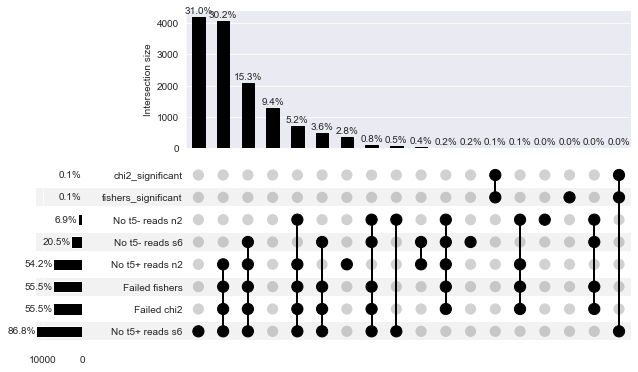

In [207]:
# A lot of genes seem to be failing chi2 b/c of zero values. How many?:
print(super_df[super_df.chi2_p_value.isna()].shape[0])
print(super_df.chi2_p_value.shape[0])
# print(super_df)

def boolDF_to_upsetPlot(input_df: pd.DataFrame):
    import upsetplot
    upset_format_data = upsetplot.from_indicators(lambda lambda_df: lambda_df.select_dtypes(bool), data=input_df)
    fig = plt.figure()
    upset = upsetplot.UpSet(upset_format_data, sort_by='cardinality', sort_categories_by='cardinality', min_subset_size=0, min_degree=0, show_percentages=True)
    upset.plot(fig=fig)
    fig.savefig(f"{get_dt(for_file=True)}_noReads_upset.png")

super_df["No t5+ reads n2"] = super_df["gene_rpm_n2_t5+"] == 0
super_df["No t5- reads n2"] = super_df["gene_rpm_n2_t5-"] == 0
super_df["No t5+ reads s6"] = super_df["gene_rpm_s6_t5+"] == 0
super_df["No t5- reads s6"] = super_df["gene_rpm_s6_t5-"] == 0
super_df['Failed chi2'] = super_df['chi2_p_value'].isna()
super_df['Failed fishers'] = super_df['fishers_test_result'].isna()  # 13 genes?

base_sig_cutoff = 0.05
adjusted_sig_cutoff = base_sig_cutoff / super_df.shape[0]
print(f"P value cutoff of: {adjusted_sig_cutoff:.3g}\nFor both Chi2 and Fishers")

super_df.sort_values("chi2_p_value")
super_df["neg_log10__chi2_p_value"] = - np.log10(super_df["chi2_p_value"])
super_df["chi2_significant"] = super_df["chi2_p_value"] <= adjusted_sig_cutoff

super_df.sort_values("fishers_p_value")
super_df["neg_log10__fishers_p_value"] = - np.log10(super_df["fishers_p_value"])
super_df["fishers_significant"] = super_df["fishers_p_value"] <= adjusted_sig_cutoff

boolDF_to_upsetPlot(super_df)
zero_smg6_adapted_df = super_df[super_df["gene_rpm_s6_t5+"] == 0].sort_values("fishers_p_value")
zero_smg6_adapted_df

In [188]:
# Drop genes that don't have adapted reads in both libraries, or don't have unadapted reads in smg-6
# super_df =\
test_df = super_df[(~super_df["No t5+ reads n2"] | ~super_df["No t5+ reads s6"])][~super_df["No t5- reads s6"]]
test_df.sort_values(["gene_hits_s6_t5+", "gene_hits_n2_t5+"])
super_df = test_df

In [208]:
base_sig_cutoff = 0.05
adjusted_sig_cutoff = base_sig_cutoff / super_df.shape[0]
print(f"P value cutoff of: {adjusted_sig_cutoff:.3g}\nFor both Chi2 and Fishers")

super_df.sort_values("chi2_p_value")
super_df["neg_log10__chi2_p_value"] = - np.log10(super_df["chi2_p_value"])
super_df["chi2_significant"] = super_df["chi2_p_value"] <= adjusted_sig_cutoff

super_df.sort_values("fishers_p_value")
super_df["neg_log10__fishers_p_value"] = - np.log10(super_df["fishers_p_value"])
super_df["fishers_significant"] = super_df["fishers_p_value"] <= adjusted_sig_cutoff

plot_df = super_df.reset_index()
plot_df['is_MtDNA'] = plot_df['chr_id'] == 'MtDNA'

P value cutoff of: 3.7e-06
For both Chi2 and Fishers


In [252]:
# I want to color by genes from this pub:
# Some NMD targets from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5765348/
list_from_Muir_et_al_2018 = [
    # These are actually from Johns et al. 2007
    "rsp-2", "rsp-6", "rpl-12",
    # his one too but it's actually rpl-1 in worms? rpl-10A is human
    "rpl-10a", "rpl-1",
    # Okay, actually things from Muir et al. 2018 now (I think):
    "Y39B6A.21", "Y51A2D.13", "ZK970.7",
    "B0495.8", "F45D11.1", "F53B2.8",
    "fib-1", "fbxa-33", "linc-9",
    "nhr-109", "pho-11", "pqn-70",
    "tdp-1", "R08E5.3",
    # And a repeat from my hits:
   "rpl-7A", 
   ]

plot_df['Muir_etal_2018_target'] = plot_df['gene_name'].isin(list_from_Muir_et_al_2018)

In [254]:
fig = px.scatter(plot_df,
                 x="fraction_adapted_FC",
                 y="neg_log10__fishers_p_value",
                 hover_name="gene_name",
                 hover_data=plot_df.columns,
                 color='Muir_etal_2018_target',
                 symbol="is_MtDNA",
                 symbol_sequence=[0, 3],
                 template="plotly_white")
fig.update_traces(marker={# 'color': 'black',
                          'opacity': 0.8,
                          'size': 8})
fig.add_hline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
# fig.add_vline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
fig

In [253]:
fig = px.scatter(plot_df,
                 # x="gene_hits_s6_t5-",
                 x="delta_fraction_adapted",
                 y="neg_log10__fishers_p_value",
                 hover_name="gene_name",
                 hover_data=plot_df.columns,
                 color='Muir_etal_2018_target',
                 symbol="is_MtDNA",
                 symbol_sequence=[0, 3],
                 template="plotly_white",
                 log_x=True)
fig.update_traces(marker={# 'color': 'black',
                          'opacity': 0.8,
                          'size': 8})
fig.update_xaxes(range=[np.log10(0.01), np.log10(1.01)])
fig.add_hline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
fig

In [115]:
plot_df[plot_df['fishers_significant']][['chr_id', 'gene_name', 'gene_id',
                                         'gene_hits_n2_t5+', 'gene_hits_n2_t5-',
                                         'gene_hits_s6_t5+', 'gene_hits_s6_t5-',
                                         'n2_fraction_adapted',
                                         's6_fraction_adapted',
                                         'fishers_p_value',
                                         'fishers_significant',
                                           ]].sort_values("fishers_p_value")

,chr_id,gene_name,gene_id,gene_hits_n2_t5+,gene_hits_n2_t5-,gene_hits_s6_t5+,gene_hits_s6_t5-,n2_fraction_adapted,s6_fraction_adapted,fishers_p_value,fishers_significant
5929,X,F23A7.8,WBGene00044638,226.0,1819.0,92.0,4474.0,0.110513,0.020149,1.798052e-51,True
4248,MtDNA,ctc-1,WBGene00010964,993.0,3201.0,364.0,2679.0,0.236767,0.119619,9.567619e-38,True
4249,MtDNA,ctc-2,WBGene00010965,569.0,1807.0,218.0,1763.0,0.239478,0.110045,2.341611e-29,True
1667,II,xrn-1,WBGene00012730,276.0,7772.0,162.0,13307.0,0.034294,0.012028,8.054807e-28,True
4240,MtDNA,ctb-1,WBGene00000829,420.0,1154.0,108.0,946.0,0.266836,0.102467,1.677713e-26,True
4244,MtDNA,atp-6,WBGene00010960,243.0,1851.0,88.0,2357.0,0.116046,0.035992,1.713955e-25,True
4687,V,F19B2.5,WBGene00008944,82.0,165.0,3.0,250.0,0.331984,0.011858,5.927090e-25,True
5604,X,F23A7.4,WBGene00009069,185.0,1355.0,90.0,2419.0,0.120130,0.035871,3.565870e-24,True
3377,IV,rpl-7A,WBGene00004419,230.0,1340.0,2.0,339.0,0.146497,0.005865,1.405409e-18,True
4245,MtDNA,nduo-2,WBGene00010961,201.0,444.0,55.0,417.0,0.311628,0.116525,3.592811e-15,True


In [255]:
nmd_targets = plot_df[plot_df["fishers_significant"]][['chr_id', 'gene_name', 'gene_id', 'fishers_p_value']].query("chr_id != 'MtDNA'").sort_values('fishers_p_value')
nmd_targets_list = nmd_targets.gene_name.to_list()

# Some NMD targets from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5765348/
list_from_Muir_et_al_2018 = [
    # These are actually from Johns et al. 2007
    "rsp-2", "rsp-6", "rpl-12",
    # his one too but it's actually rpl-1 in worms? rpl-10A is human
    "rpl-10a", "rpl-1",
    # Okay, actually things from Muir et al. 2018 now (I think):
    "Y39B6A.21", "Y51A2D.13", "ZK970.7",
    "B0495.8", "F45D11.1", "F53B2.8",
    "fib-1", "fbxa-33", "linc-9",
    "nhr-109", "pho-11", "pqn-70",
    "tdp-1", "R08E5.3",
    # And a repeat from my hits:
   "rpl-7A", 
   ]

for gene in list_from_Muir_et_al_2018:
    nmd_targets_list.append(gene)

for gene_name in nmd_targets_list:
    hits_or_rpm = 'rpm'
    try:
        row = plot_df.query(f'gene_name == "{gene_name}"').reset_index()
        array = np.array([[row[f"gene_{hits_or_rpm}_n2_t5-"][0],
                       row[f"gene_{hits_or_rpm}_s6_t5-"][0]],
                      [row[f"gene_{hits_or_rpm}_n2_t5+"][0],
                       row[f"gene_{hits_or_rpm}_s6_t5+"][0]]])
        little_df = pd.DataFrame(array, columns=['n2', 'smg-6'], index=['t5 -', 't5 +'])
        print(f"\n{gene_name} ({row['gene_id'][0]}) Chr: {row['chr_id'][0]}")
        print(f"  Fisher's p value: {row['fishers_p_value'][0]:0.3g}")
        
        column_width = 15
        print(f"            |{'Wildtype:':^{column_width}}|{'smg-6 KO':^{column_width}}|")
        print(f"    Adapted:|{array[0][0]:>{column_width-4}.3f} rpm|{array[0][1]:>{column_width-4}.3f} rpm|")
        print(f"  Unadapted:|{array[1][0]:>{column_width-4}.3f} rpm|{array[1][1]:>{column_width-4}.3f} rpm|")
        # print(little_df, '\n\n')
    except KeyError:
        print(f"\nFailed to find entry for {gene_name}")




F23A7.8 (WBGene00044638) Chr: X
  Fisher's p value: 1.8e-51
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|   3836.751 rpm|  27564.537 rpm|
  Unadapted:|    476.694 rpm|    566.817 rpm|

xrn-1 (WBGene00012730) Chr: II
  Fisher's p value: 8.05e-28
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|  16393.201 rpm|  81985.090 rpm|
  Unadapted:|    582.157 rpm|    998.090 rpm|

F19B2.5 (WBGene00008944) Chr: V
  Fisher's p value: 5.93e-25
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|    348.029 rpm|   1540.262 rpm|
  Unadapted:|    172.960 rpm|     18.483 rpm|

F23A7.4 (WBGene00009069) Chr: X
  Fisher's p value: 3.57e-24
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|   2858.053 rpm|  14903.580 rpm|
  Unadapted:|    390.214 rpm|    554.494 rpm|

rpl-7A (WBGene00004419) Chr: IV
  Fisher's p value: 1.41e-18
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|   2826.414 rpm|   2088.596 rpm|
  Unadapted:|    485.131 rpm|     12.322 rpm|

o

In [162]:

def with_dash_for_click_to_copy(input_df: pd.DataFrame):
    from jupyter_dash import JupyterDash
    import json
    from dash import dcc, html, callback_context, dash_table
    import dash_bootstrap_components as dbc
    from dash.dependencies import Input, Output
    import pyperclip
    from webbrowser import open as open_webpage
    # Example for coping to clipboard:
    # pyperclip.copy('The text to be copied to the clipboard.')
    
    merge_df = input_df.copy()
    
    app = JupyterDash(__name__)

    app.layout = dbc.Container(
        [
            dbc.Row(
                # Top row w/ buttons and slider
                [
                    dbc.Col(
                        [
                            dcc.Dropdown(
                                id='x_col',
                                options=[{'label': i, 'value': i} for i in merge_df.columns],
                                value="fraction_adapted_FC"),
                            dcc.Dropdown(
                                id='y_col',
                                options=[{'label': i, 'value': i} for i in merge_df.columns],
                                value="neg_log10__fishers_p_value"),
                        ],
                        width=8,
                        style={'height': '100%'}
                    ),
                    dbc.Col(
                        [
                            html.Button(
                                'Copy selected GENE_NAME',
                                id='btn-nclicks-2',
                                n_clicks=0),
                            html.Button(
                                'Copy selected WBGENE_ID',
                                id='btn-nclicks-1',
                                n_clicks=0),
                            html.Button(
                                'Open WormBase',
                                id='btn-nclicks-3',
                                n_clicks=0),
                            html.Div(
                                id='container-button-timestamp'
                            ),
                            html.Div(
                                id='selected-data'
                            ),
                            html.Div(
                                id='contingency-table',
                            ),
                        ],
                        width=4,
                        style={'height': '100%'}
                    ),
                ],
                className="h-10",
            ),
            dbc.Row(
                # Row for graph!
                [
                    dcc.Graph(id='primary-scatter',
                              style=
                              {
                                  'width': '120vh',
                                  'height': '80vh',
                              }
                              ),
                ],
                className='h-60',
            ),
        ],
        style={'height': '100%', 'width': '100%'},
    )

    @app.callback(Output('primary-scatter', 'figure'),
                  [Input('x_col', 'value'),
                   Input('y_col', 'value'), ])
    def main_plot(x_col, y_col):
        fig = px.scatter(merge_df,
                         x=x_col,
                         y=y_col,
                         hover_name="gene_name",
                         # hover_data=[merge_df.columns],
                         # color="fishers_significant",
                         symbol="is_MtDNA",
                         symbol_sequence=[0, 3],
                         template="plotly_white",
                         opacity=0.8,
                          custom_data=["gene_id", "gene_name"])
        fig.update_traces(marker={'color': 'black',
                                  'opacity': 0.5,
                                  'size': 8})
        fig.add_hline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
        # fig.add_vline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
        fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0},
                          hovermode='closest', clickmode="event+select",
                          template='plotly_white')
        # fig.update_xaxes(type='log')
        # fig.update_yaxes(type='log')
        return fig

    @app.callback(
        Output('selected-data', 'children'),
        [Input('primary-scatter', 'selectedData')])
    def display_selected_data(selectedData):
        if not selectedData:
            return "No points selected"
        return_data = []
        for point_dict in selectedData['points']:
            gene_id, gene_name = point_dict['customdata'][0:2]
            # print(point_dict['customdata'])
            return_data.append({'Gene Name': gene_name,
                                'Gene ID': gene_id})
        return json.dumps(return_data, indent=2)
    
    @app.callback(
        Output('contingency-table', 'children'),
        [Input('primary-scatter', 'selectedData')])
    def display_selected_table(selectedData):
        if not selectedData:
            return "No points selected"
        return_tables =[]
        for point_dict in selectedData['points']:
            gene_id, gene_name = point_dict['customdata'][0:2]
            
            row = plot_df.query(f'gene_id == "{gene_id}"').reset_index()
            # array = np.array([[row["gene_hits_n2_t5-"][0],
            #                    row["gene_hits_s6_t5-"][0]],
            #                   [row["gene_hits_n2_t5+"][0],
            #                    row["gene_hits_s6_t5+"][0]]])
            array = np.array([[row["gene_rpm_n2_t5-"][0],
                   row["gene_rpm_s6_t5-"][0]],
                  [row["gene_rpm_n2_t5+"][0],
                   row["gene_rpm_s6_t5+"][0]]])
            pd.options.display.float_format = '{:,.2g}'.format
            little_df = pd.DataFrame(array, columns=['n2', 'smg-6'], index=['t5 -', 't5 +']).reset_index()
            little_df_columns = [{"name": i, "id": i} for i in little_df.columns]
            table = dash_table.DataTable(data=little_df.to_dict('records'), 
                                         columns=little_df_columns,
                                         )
            return [table]

    @app.callback(
        Output('container-button-timestamp', 'children'),
        [Input('btn-nclicks-1', 'n_clicks'),
         Input('btn-nclicks-2', 'n_clicks'),
         Input('btn-nclicks-3', 'n_clicks'),
         Input('primary-scatter', 'figure'),
         Input('primary-scatter', 'selectedData')])
    def button_click(gene_id, gene_name, open_worm_base, scatter_fig, selectedData):
        changed_id = [p['prop_id'] for p in callback_context.triggered][0]
        if not selectedData:
            return_data = {'gene_name': [],
                           'gene_id': []}
        else:
            return_data = {'gene_name': [],
                           'gene_id': []}
            for point_dict in selectedData['points']:
                gene_id, gene_name = point_dict['customdata'][0:2]
                return_data["gene_name"].append(gene_name)
                return_data["gene_id"].append(gene_id)
        if 'btn-nclicks-2' in changed_id:
            msg = 'Copy gene_id'
            # print(scatter_fig)
            if len(return_data['gene_name']) == 1:
                pyperclip.copy(return_data['gene_name'][0])
            elif len(return_data['gene_name']) > 1:
                pyperclip.copy(', '.join(return_data['gene_name']))
        elif 'btn-nclicks-1' in changed_id:
            msg = 'Copy gene_name'
            if len(return_data['gene_id']) == 1:
                pyperclip.copy(return_data['gene_id'][0])
            elif len(return_data['gene_id']) > 1:
                pyperclip.copy(', '.join(return_data['gene_id']))
        elif 'btn-nclicks-3' in changed_id:
            msg = 'Open worm base'
            if len(return_data['gene_id']) == 1:
                wbgene_id = return_data['gene_id'][0]
                open_webpage(f"https://wormbase.org/species/c_elegans/gene/{wbgene_id}", new=1)
            elif len(return_data['gene_id']) > 1:
                for i, wbgene_id in enumerate(return_data['gene_id']):
                    if i == 0:
                        open_webpage(f"https://wormbase.org/species/c_elegans/gene/{wbgene_id}", new=1)
                    else:
                        open_webpage(f"https://wormbase.org/species/c_elegans/gene/{wbgene_id}", new=2)
        else:
            msg = '*None of the buttons*'
        return html.Div(f"{msg} was most recently clicked")

    app.run_server(mode='external')

# This doesn't work lol
with_dash_for_click_to_copy(plot_df.reset_index())

Dash app running on http://127.0.0.1:8050/


In [166]:
gene_name = 'rpl-12'
hits_or_rpm = 'rpm'

row = plot_df.query(f'gene_name == "{gene_name}"').reset_index()
array = np.array([[row[f"gene_{hits_or_rpm}_n2_t5-"][0],
                   row[f"gene_{hits_or_rpm}_s6_t5-"][0]],
                  [row[f"gene_{hits_or_rpm}_n2_t5+"][0],
                   row[f"gene_{hits_or_rpm}_s6_t5+"][0]]])
little_df = pd.DataFrame(array, columns=['n2', 'smg-6'], index=['t5 -', 't5 +'])
little_df

,n2,smg-6
t5 -,3.7e+03,3.2e+03
t5 +,1e+02,37
